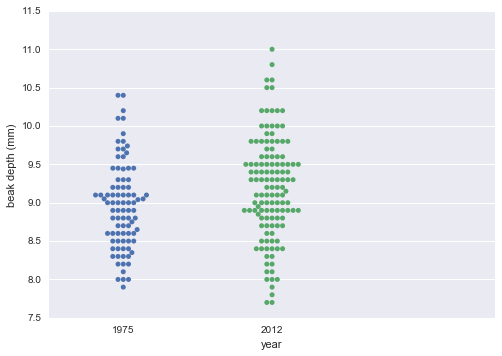

In [16]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Scd-bd-1975-2012.csv')
df1 = pd.read_csv('Scd-bl-1975-2012.csv')

# Create bee swarm plot
_ = sns.swarmplot(x = 'year', y = 'beak_depth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
_ = plt.show()

In [17]:
bd_1975 = np.array(df.loc[df['year'] == '1975']['beak_depth'])
bd_2012 = np.array(df.loc[df['year'] == '2012']['beak_depth'])

bl_1975 = np.array(df1.loc[df['year'] == '1975']['beak_length'])
bl_2012 = np.array(df1.loc[df['year'] == '2012']['beak_length'])

In [20]:
# ecdf function
def ecdf(data):
    y=np.arange(1, len(data)+1)/float(len(data))
    x=np.sort(data)
    return x,y

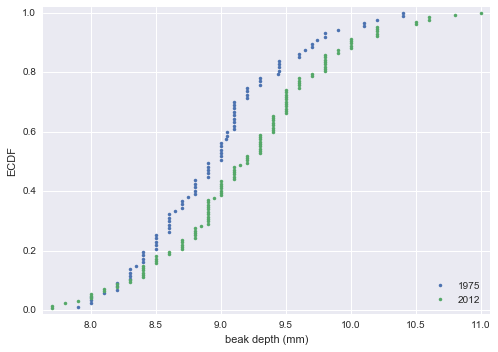

In [21]:
# ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plotting the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
_ = plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

In [52]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [23]:
# difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

# samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.226220472441 mm
95% confidence interval = [ 0.05902851  0.39101292] mm


In [24]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, size=10000)

# replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0034


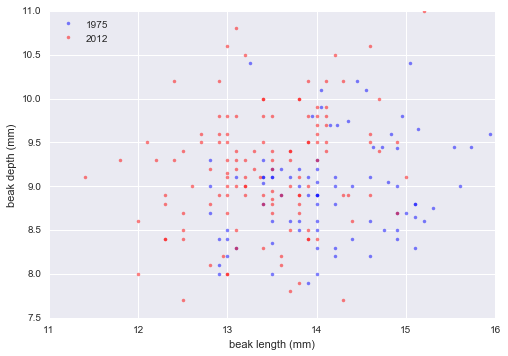

In [25]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

In [27]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975,1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012,1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.179800983507 conf int = [ 0.02765123  0.30721062]
1975: intercept = 6.42104477864 conf int = [ 4.60279212  8.56696566]
2012: slope = 0.210656682008 conf int = [ 0.04382872  0.382444  ]
2012: intercept = 6.35899216707 conf int = [ 4.08841924  8.56607488]


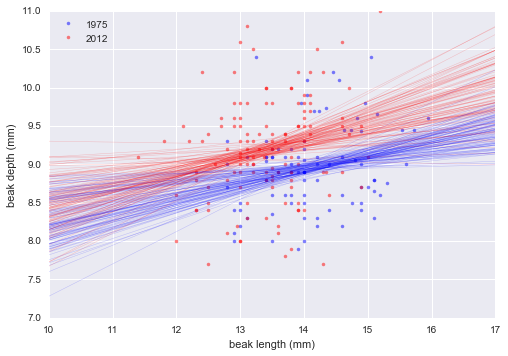

In [28]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

In [29]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5808446979 conf int = [ 1.54998394  1.61192745]
2012: mean ratio = 1.46750635956 conf int = [ 1.44007275  1.49468368]


In [42]:
df2=pd.read_csv('fortis-bd.csv')
df3=pd.read_csv('scanden-bd.csv')
df2.shape, df3.shape
print(df2)

     Mid-offspr  Male_BD  Female BD
0         10.70    10.90       9.30
1          9.78    10.70       8.40
2          9.48    10.70       8.10
3          9.60    10.70       9.80
4         10.27     9.85      10.40
5          9.50     9.80       9.60
6          9.00     9.90       8.20
7          7.46     9.30       5.50
8          7.65     9.40       8.60
9          8.63     9.40       7.90
10         9.81     9.40       9.85
11         9.40    10.10       9.70
12         9.48    10.10       9.00
13         8.75     8.30       9.80
14         7.60     8.70       8.00
15        10.00    10.10      10.10
16        10.09    10.10      10.10
17         9.74     9.70      10.10
18         9.64     9.70      10.75
19         8.49    11.80       8.20
20        10.15    10.40      10.70
21        10.28    10.50      10.40
22         9.20    10.30       8.10
23        10.01    10.30      10.10
24         9.03     8.60       9.30
25         9.94     9.50      10.60
26        10.50    10.00    

In [48]:
#computing average for G. fortis as its not given
bd_parent_fortis = (df2['Male_BD'].values + df2['Female BD'].values)/2
bd_offspring_fortis = df2['Mid-offspr'].values
bd_parent_scandens = df3['mid_parent'].values
bd_offspring_scandens = df3['mid_offspring'].values

print(bd_parent_fortis)

[ 10.1     9.55    9.4    10.25   10.125   9.7     9.05    7.4     9.
   8.65    9.625   9.9     9.55    9.05    8.35   10.1    10.1     9.9
  10.225  10.     10.55   10.45    9.2    10.2     8.95   10.05   10.2
   9.5     9.925   9.95   10.05    8.75    9.2    10.15    9.8    10.7
  10.5     9.55   10.55   10.475   8.65   10.7     9.1     9.4    10.3
   9.65    9.5     9.7    10.525   9.95   10.1     9.75   10.05    9.9    10.
   9.1     9.45    9.25    9.5    10.     10.525   9.9    10.4     8.95
   9.4    10.95   10.75   10.1     8.05    9.1     9.55    9.05   10.2    10.
  10.55   10.75    8.175   9.7     8.8    10.75    9.3     9.7     9.6
   9.75    9.6    10.45   11.     10.85   10.15   10.35   10.4     9.95
   9.1    10.1     9.85    9.625   9.475   9.      9.25    9.1     9.25
   9.2     9.95    8.65    9.8     9.4     9.      8.55    8.75    9.65
   8.95    9.15    9.85   10.225   9.825  10.      9.425  10.4     9.875
   8.95    8.9     9.35   10.425  10.     10.175   9.875  

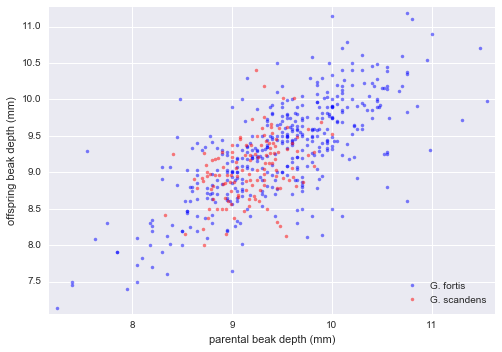

In [49]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Set margins
plt.margins(0.02)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()

In [56]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

In [57]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.41170636294 [ 0.26393921  0.55152418]
G. fortis: 0.728341239552 [ 0.66809718  0.77443126]


In [58]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.548534086869 [ 0.35098537  0.73599511]
G. fortis: 0.722905191144 [ 0.64777767  0.80240174]


In [59]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / (len(perm_replicates))

# Print the p-value
print('p-val =', p)

p-val = 0.0
